# Transformer pipeline
- Raw text - 문장이 입력
- Input IDs - 원시 텍스트를 모델이 이해할수 있는 숫자로 변환
- Logits - 이 숫자가 모델을 통과하여 Logits로 출력
- Predictions - 마지막 사후 처리로 Logits를 라벨과 점수로 출력
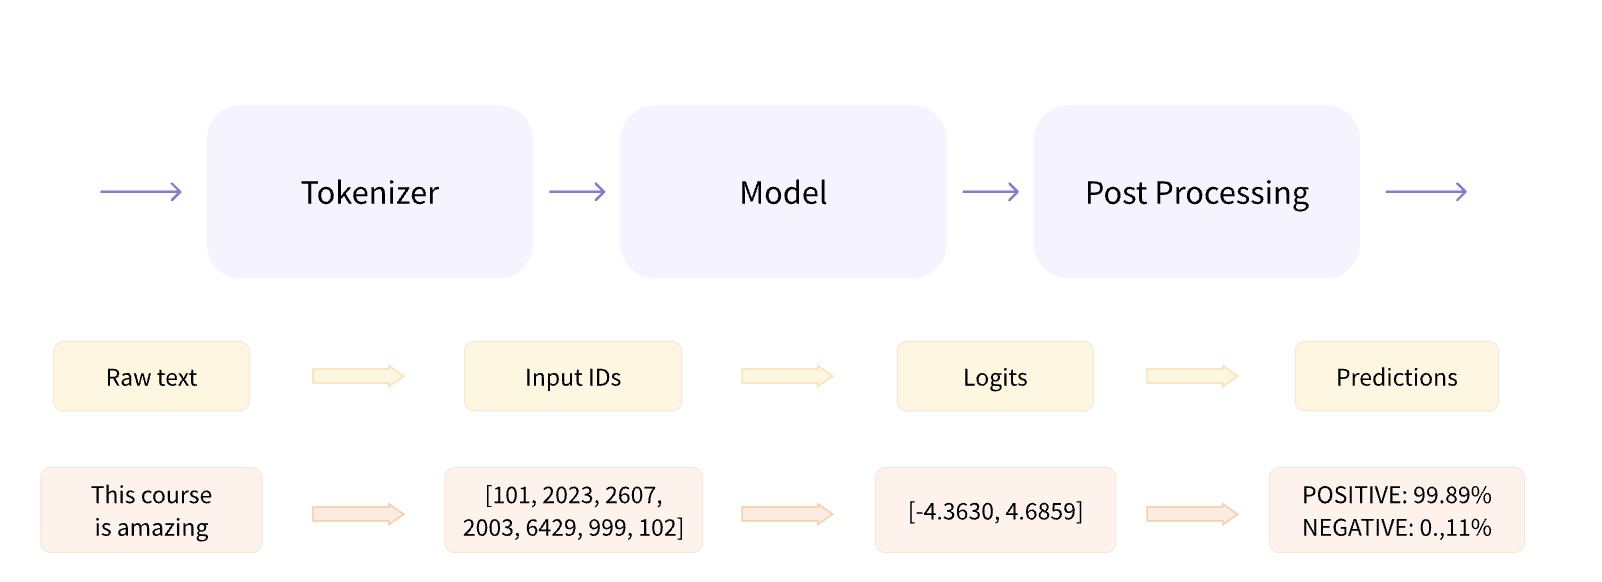

# 더 정확한 NLP processing
1. 텍스트는 토큰이라는 작은 단위로 분리 됨
- ['나는 부산사는 윤승현이다, 현재 나이는 26이다.'] -> [[cls], '나는' ,'부산사는' ,'윤승현이다' [sep] ,'현재' ,'나이는', '26이다', [sep]]
2. 각 토크나이저는 pretrain model에서의 vocab에 있는 고유 ID와 Mapping 시킴
- 이러한 토크나이저를 사용하기 위해 아래 코드와 같은 API를 제공함

---


In [4]:
# 1. 필요한 라이브러리를 가져옵니다.
from transformers import AutoTokenizer

# 2. 사전 학습된 토크나이저를 로드합니다.
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"  # 모델 체크포인트를 지정합니다.
tokenizer = AutoTokenizer.from_pretrained(checkpoint)  # 모델과 일치하는 토크나이저를 로드합니다.

# 3. 원시 텍스트 입력을 준비합니다.
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]

# 4. 입력을 토큰화합니다.
inputs = tokenizer(
    raw_inputs,
    padding=True,  # 짧은 시퀀스를 가장 긴 시퀀스와 일치하도록 패딩합니다.
    truncation=True,  # 모델의 최대 길이에 맞게 긴 시퀀스를 잘라냅니다.
    return_tensors="pt",  # 추가 처리를 위해 PyTorch 텐서를 반환합니다.
)

# 5. 토큰화된 입력을 인쇄합니다.
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


# 모델 살펴보기
- 배치 크기 : 한 번에 처리되는 시퀀스 수(예제에서는 2)입니다.
- 시퀀스 길이 : 시퀀스의 숫자 표현 길이입니다(이 예에서는 16).
- 숨겨진 크기 : 각 모델 입력의 벡터 차원입니다.

In [10]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)


torch.Size([2, 16, 768])


## 분류 헤드달기
- AutoModelForSequenceClassification 라이브러리를 이용하여 logits와 분류 헤드를 달아서 분류하기
- model에 있는 속성값 id2label를 이용하여 분류

In [12]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits.shape)

import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
print(model.config.id2label)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


torch.Size([2, 2])
tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)
{0: 'NEGATIVE', 1: 'POSITIVE'}


# 모델 생성하기

In [14]:
from transformers import BertConfig, BertModel
# config(설정)을 만듭니다.
config = BertConfig()
# 해당 config에서 모델을 생성합니다.
model = BertModel(config)

In [19]:
config

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [16]:
from transformers import BertModel
# 모델불러오기
model = BertModel.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [17]:
# 모델 저장
model.save_pretrained( "directory_on_my_computer" )

# 모델을 사용해서 예측 해보기

In [24]:
import torch
# vocab의 숫자로 mapping 된 토크나이저
encoded_sequences = [
    [101, 7592, 999, 102],
    [101, 4658, 1012, 102],
    [101, 3835, 999, 102],
]
# 모델에 들어갈수 있게 tensor 형태로 변환
model_inputs = torch.tensor(encoded_sequences)
print(model_inputs)

tensor([[ 101, 7592,  999,  102],
        [ 101, 4658, 1012,  102],
        [ 101, 3835,  999,  102]])


In [23]:
# 모델에 넣어 logits형태로 변경
output = model(model_inputs)
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 4.4496e-01,  4.8276e-01,  2.7797e-01,  ..., -5.4032e-02,
           3.9394e-01, -9.4770e-02],
         [ 2.4943e-01, -4.4093e-01,  8.1772e-01,  ..., -3.1917e-01,
           2.2992e-01, -4.1172e-02],
         [ 1.3668e-01,  2.2518e-01,  1.4502e-01,  ..., -4.6915e-02,
           2.8224e-01,  7.5566e-02],
         [ 1.1789e+00,  1.6738e-01, -1.8187e-01,  ...,  2.4671e-01,
           1.0441e+00, -6.1970e-03]],

        [[ 3.6436e-01,  3.2464e-02,  2.0258e-01,  ...,  6.0111e-02,
           3.2451e-01, -2.0995e-02],
         [ 7.1866e-01, -4.8725e-01,  5.1740e-01,  ..., -4.4012e-01,
           1.4553e-01, -3.7545e-02],
         [ 3.3223e-01, -2.3271e-01,  9.4877e-02,  ..., -2.5268e-01,
           3.2172e-01,  8.1079e-04],
         [ 1.2523e+00,  3.5754e-01, -5.1320e-02,  ..., -3.7840e-01,
           1.0526e+00, -5.6255e-01]],

        [[ 2.4042e-01,  1.4718e-01,  1.2110e-01,  ...,  7.6062e-02,
           3.3564e-01,  2